In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

### Emotions

In [3]:
EMOTIONS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [4]:
def extract_features(file_path, max_pad_len=174):
    audio, sr = librosa.load(file_path, duration=3, sr=22050)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    
    return mfccs

In [5]:
def get_emotion_from_filename(filename):
    parts = filename.split('-')
    if len(parts) >= 3:
        emotion_code = parts[2]
        return EMOTIONS.get(emotion_code, 'unknown')
    return 'unknown'

In [6]:
def load_data(data_path):
    features = []
    labels = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                emotion = get_emotion_from_filename(file)
                if emotion == 'unknown':
                    continue
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(emotion)
                    if len(features) % 100 == 0:
                        print(f"Processed {len(features)} files")
    
    print(f"Total files processed: {len(features)}")
    return np.array(features), np.array(labels)

In [7]:
def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([   
        layers.Input(shape=input_shape),
        layers.Reshape((*input_shape, 1)),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
    
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [8]:
def train_model(data_path, model_type='cnn', epochs=50, batch_size=32):
    X, y = load_data(data_path)
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = keras.utils.to_categorical(y_encoded)
    
    print(f"\nEmotion distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for emotion, count in zip(unique, counts):
        print(f"  {emotion}: {count}")
    
    plt.figure(figsize=(8,5))
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts, color='teal')
    plt.xticks(rotation=45)
    plt.title('Emotion Distribution in Dataset')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)
    
    print(f"\nTraining set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"Input shape: {X_train.shape[1:]}")
    
    num_classes = len(np.unique(y_encoded))
    model = create_cnn_model(X_train.shape[1:], num_classes)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("\nModel Summary:")
    model.summary()


    print(f"\nTraining {model_type.upper()} model")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    
    print(f"\nModel Accuracy: {accuracy:.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Emotion Classification")
    plt.show()
    
    with open('label_encoder_dl.pkl', 'wb') as f:
        pickle.dump(le, f)
    
    return model, le, history

In [9]:
def predict_emotion(audio_path, model=None, le=None):
    model = keras.models.load_model('emotion_model_dl.h5')
    
    if le is None:
        with open('label_encoder_dl.pkl', 'rb') as f:
            le = pickle.load(f)
    features = extract_features(audio_path)
    if features is None:
        return None
    features = features.reshape(1, *features.shape)

    prediction = model.predict(features, verbose=0)
    emotion_idx = np.argmax(prediction)
    emotion = le.inverse_transform([emotion_idx])[0]
    confidence = prediction[0][emotion_idx]
    top_3_idx = np.argsort(prediction[0])[-3:][::-1]
    top_3_emotions = [(le.inverse_transform([idx])[0], prediction[0][idx]) 
                      for idx in top_3_idx]
    
    return emotion, confidence, top_3_emotions

Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files
Processed 600 files
Processed 700 files
Processed 800 files
Processed 900 files
Processed 1000 files
Processed 1100 files
Processed 1200 files
Processed 1300 files
Processed 1400 files
Total files processed: 1440

Emotion distribution:
  angry: 192
  calm: 192
  disgust: 192
  fearful: 192
  happy: 192
  neutral: 96
  sad: 192
  surprised: 192


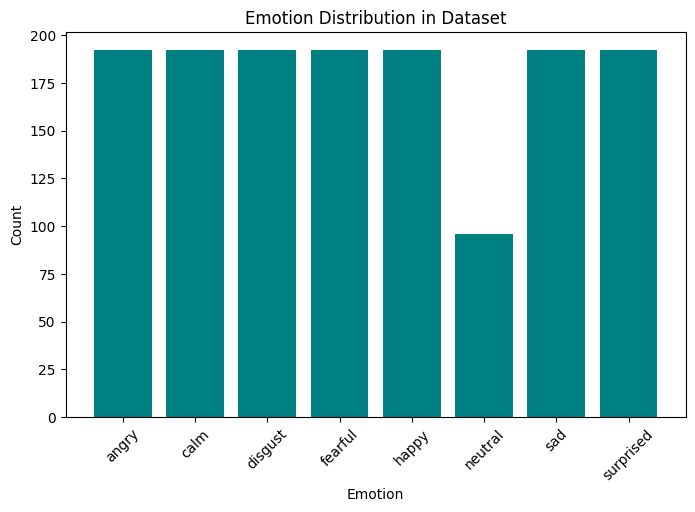


Training set: 1152 samples
Test set: 288 samples
Input shape: (40, 174)

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 40, 174, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 174, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 174, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 21, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 21, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13440)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,440,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,569,928 (13.62 MB)

 Trainable params: 3,568,712 (13.61 MB)

 Non-trainable params: 1,216 (4.75 KB)


Training CNN model
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 377ms/step - accuracy: 0.2101 - loss: 2.7281 - val_accuracy: 0.1319 - val_loss: 9.2915
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 371ms/step - accuracy: 0.3038 - loss: 2.2554 - val_accuracy: 0.1319 - val_loss: 7.8044
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.3724 - loss: 1.8911 - val_accuracy: 0.1875 - val_loss: 3.6665
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 348ms/step - accuracy: 0.4106 - loss: 1.7454 - val_accuracy: 0.3819 - val_loss: 1.8703
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.4280 - loss: 1.6296 - val_accuracy: 0.3472 - val_loss: 1.6752
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.4766 - loss: 1.5096 - val_accuracy: 0.3299 - val_loss: 2.0443
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.4922 - loss: 1.5017 - val_accuracy: 0.2986 - val_loss: 2.2668
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.5095 - los

In [ ]:
path_to_files = "./RAVDESS" 
model, le, history = train_model(path_to_files, model_type='cnn', epochs=50)

In [ ]:
SR = 16000
DURATION = 3.5
N_MELS = 64
def extract_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=SR)
    y = librosa.util.fix_length(y, size=int(SR * DURATION))
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)
    return mel_db

In [ ]:
actor = str(np.random.randint(1, 25)).zfill(2)
random_emotion = str(np.random.randint(1, 9)).zfill(2)
test_file = "./RAVDESS/Actor_"+actor+"/03-01-"+random_emotion+"-01-01-01-"+actor+".wav"
print(f"\nTest File: {test_file}")
emotion, confidence, top_3 = predict_emotion(test_file, model, le)
print(f"\nPredicted emotion: {emotion} (confidence: {confidence:.2%})")
print("\nTop 3 predictions:")
for emo, conf in top_3:
    print(f"  {emo}: {conf:.2%}")


mel = extract_mel_spectrogram(test_file)
print("Mel shape:", mel.shape)
librosa.display.specshow(mel, sr=SR, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Sample Mel-Spectrogram - Emotion {EMOTIONS[random_emotion]}")
plt.show()